In [1]:
from cellpose import models, io
from cellpose.io import *
from collections import defaultdict
import glob
import imagej
from jpype import JArray, JInt
import matplotlib.pyplot as plt
import os
import re
import pandas
from pandas import DataFrame
from pathlib import Path
import scyjava
import seaborn
import geopandas
import shutil
import tkinter as tk
from tkinter import filedialog
from PIL import Image
from zipfile import ZipFile
import csv
import numpy as np
from skimage.measure import find_contours, label
from jpype import JArray, JInt
import random
import time
from math import isnan 

In [2]:
scyjava.config.add_option('-Xmx30g') # this is to assign RAM to the java session
ij = imagej.init('/home/saka/sw/local/fiji2/2023', mode='interactive')
ij.ui().showUI()
ij.getVersion()

'2.14.0/1.54f'

opening Experiment-248
opening Experiment-244
opening Experiment-245
opening Experiment-247
opening Experiment-243
opening Experiment-241
opening Experiment-239
opening Experiment-242
opening Experiment-240
opening Experiment-238


In [3]:
# Dialog window to get the path of the working directory
root = tk.Tk()
root.withdraw()
# Set the path to the directory containing the images
directory_path = filedialog.askdirectory()

In [4]:
w = scyjava.jimport('ij.WindowManager')
IC = scyjava.jimport('ij.plugin.ImageCalculator')
rm = ij.RoiManager.getRoiManager()

# Different plugin needed for the workflow
showPolygonRoi = scyjava.jimport('ij.gui.PolygonRoi')
Overlay = scyjava.jimport('ij.gui.Overlay')
Regions = scyjava.jimport('net.imglib2.roi.Regions')
LabelRegions = scyjava.jimport('net.imglib2.roi.labeling.LabelRegions')
ZProjector = scyjava.jimport('ij.plugin.ZProjector')()
Duplicator = scyjava.jimport('ij.plugin.Duplicator')()
ov = Overlay()
Model =  scyjava.jimport('fiji.plugin.trackmate.Model')
Settings= scyjava.jimport('fiji.plugin.trackmate.Settings')
TrackMate = scyjava.jimport('fiji.plugin.trackmate.TrackMate')
Settings= scyjava.jimport('fiji.plugin.trackmate.Settings')
TrackMate = scyjava.jimport('fiji.plugin.trackmate.TrackMate')
Logger= scyjava.jimport('fiji.plugin.trackmate.Logger')
DetectorKeys= scyjava.jimport('fiji.plugin.trackmate.detection.DetectorKeys') 
ExportTracksToXML= scyjava.jimport('fiji.plugin.trackmate.action.ExportTracksToXML') 
TmXmlWriter= scyjava.jimport('fiji.plugin.trackmate.io.TmXmlWriter')
LogRecorder = scyjava.jimport('fiji.plugin.trackmate.util.LogRecorder')
SparseLAPTrackerFactory= scyjava.jimport('fiji.plugin.trackmate.tracking.jaqaman.SparseLAPTrackerFactory')
TMUtils = scyjava.jimport('fiji.plugin.trackmate.util.TMUtils')
HyperStackDisplayer = scyjava.jimport('fiji.plugin.trackmate.visualization.hyperstack.HyperStackDisplayer')
SelectionModel = scyjava.jimport('fiji.plugin.trackmate.SelectionModel')
CellposeDetectorFactory = scyjava.jimport('fiji.plugin.trackmate.cellpose.CellposeDetectorFactory')
FeatureFilter = scyjava.jimport('fiji.plugin.trackmate.features.FeatureFilter')
DisplaySetting = scyjava.jimport('fiji.plugin.trackmate.gui.displaysettings.DisplaySettings')
DisplaySettingsIO = scyjava.jimport('fiji.plugin.trackmate.gui.displaysettings.DisplaySettingsIO')
CaptureOverlayAction = scyjava.jimport('fiji.plugin.trackmate.action.CaptureOverlayAction')
PretrainedModel= scyjava.jimport('fiji.plugin.trackmate.cellpose.CellposeSettings.PretrainedModel')
ThresholdDetectorFactory= scyjava.jimport('fiji.plugin.trackmate.detection.ThresholdDetectorFactory')
TrackScheme = scyjava.jimport('fiji.plugin.trackmate.visualization.trackscheme.TrackScheme')
TrackTableView = scyjava.jimport('fiji.plugin.trackmate.visualization.table.TrackTableView')
AllSpotsTableView = scyjava.jimport('fiji.plugin.trackmate.visualization.table.AllSpotsTableView')

In [5]:
def image_rescaling(imp, distance, known, unit, z_interval):
    data_info = {}
    for element in range(len(imp.dims)):
        name = imp.dims[element]
        data_info[name] = imp.shape[element]
        print(name)
    num_frame = data_info['Z']
    xy_scale = known / distance
    if imp.dims[2] == 'C':
        num_channel = data_info['C']
    else:
        num_channel = 1
    rescaling = ij.IJ.run(imp, "Properties...", f"channels={num_channel} slices={num_frame} frames=1 pixel_width={xy_scale} pixel_height={xy_scale} voxel_depth={z_interval} frame=[1 frame]")


def get_bact_rois(bact_path, distance, known, unit, threshold_low, threshold_high, threshold_size):
    file_pattern = os.path.join(bact_path, "*.tif")
    file_list = glob.glob(file_pattern)
    for file_path in file_list:
        f_name = os.path.basename(file_path)
        if f_name.startswith('bact'):
            if not file_path.endswith('overlay.tif'):
                imp = ij.IJ.openImage(file_path)
                f_name = os.path.basename(file_path)
                f_name = os.path.splitext(f_name)[0]
                imp.show()
                ij.IJ.run(imp, "Select None", "")
                ij.IJ.run("Smooth", "stack")
                ij.IJ.run("Smooth", "stack")
                ij.py.run_macro(f'run("Set Scale...", "distance={distance} known={known} unit={unit}");')    
                ij.IJ.run("Set Measurements...", f'area centroid stack decimal=2')
                ij.IJ.setAutoThreshold(imp, "Default dark")
                ij.IJ.setRawThreshold(imp, threshold_low, threshold_high)
                ij.IJ.run(imp, "Convert to Mask", "background=Dark black");
                ij.IJ.run(imp, "Analyze Particles...", f"size={threshold_size}-Infinity display add stack");
                #ij.IJ.run(imp, "Measure", "");
                roi_count = rm.getCount()
                if roi_count == 0:
                    print(f"this {f_name} has no bacteria")
                    ij.py.run_macro('close("*");')
                elif roi_count == 1:
                    rm.save(f"{bact_path}" + f"{f_name}_bactROI.roi")
                    output_path = Path(f"{bact_path}{f_name}_bactROI.csv").as_posix()
                    ij.IJ.saveAs("Results", output_path)
                    ij.IJ.run("Clear Results")
                    ij.py.run_macro('close("*");')
                    rm.runCommand("Reset")                    
                else:
                    rm.save(f"{bact_path}" + f"{f_name}_bactROI.zip")
                    output_path = Path(f"{bact_path}{f_name}_bactROI.csv").as_posix()
                    ij.IJ.saveAs("Results", output_path)
                    ij.IJ.run("Clear Results")
                    ij.py.run_macro('close("*");')
                    rm.runCommand("Reset")

def circlesofhell(bact_roi_path, distance, known_scale, unit, imp):
    roi_pattern = os.path.join(bact_roi_path, "*.roi")
    roi_list = glob.glob(roi_pattern)
    for roi in roi_list:
        roi_basename = os.path.basename(roi)
        roi_corename = os.path.splitext(roi_basename)[0]
        open_roi = rm.open(roi)
        rm.select(0)
        enlarged = ij.IJ.run("Enlarge...", "enlarge=1 pixel")
        rm.addRoi(enlarged)
        for n in range(0,3):
            rm.select(1+n)
            enlarged = ij.IJ.run("Enlarge...", "enlarge=1 pixel")
            rm.addRoi(enlarged)
        rm.select(0)
        ij.py.run_macro(f'run("Set Scale...", "distance={distance} known={known_scale} unit={unit}");')  
        ij.IJ.run("Measure")
        imp.removeScale()
        ij.IJ.run("Make Band...", "band=1")
        ij.py.run_macro(f'run("Set Scale...", "distance={distance} known={known_scale} unit={unit}");')  
        ij.IJ.run("Measure")
        imp.removeScale()
        for n in range(0,4):
            rm.select(1+n)
            ij.IJ.run("Make Band...", "band=1")
            ij.py.run_macro(f'run("Set Scale...", "distance={distance} known={known_scale} unit={unit}");')  
            ij.IJ.run("Measure")
            imp.removeScale()
        rm.runCommand("Reset")
        output_path = f"{bact_roi_path}/{roi_corename}.csv"
        saving = ij.IJ.saveAs("Results", output_path)
        ij.IJ.run("Clear Results")

def saving_rois(bact_path):
    #Saving ROIs indidually into a separate folder
    file_pattern = os.path.join(bact_path, "*.tif")
    file_list = glob.glob(file_pattern)
    for file_path in file_list:
        if not file_path.endswith('overlay.tif'):
            basename = os.path.basename(file_path)
            corename = os.path.splitext(basename)[0]
            if basename.startswith("bact"):
                corename2 = corename.split("bact_channel_")[1]
                imp = ij.IJ.openImage(file_path)
                ij.ui().show(imp)
                input_csv = Path(f"{grouped}/{corename}_grouped.csv")
                if os.path.exists(input_csv):
                    bact_roi_path = bact_path + f"rois_bact/{corename2}"
                    if not os.path.exists(bact_roi_path):
                        os.makedirs(bact_roi_path)
                    df = pandas.read_csv(input_csv)
                    pouet = df['object_ID_list']
                    input_ROI = Path(f"{bact_path}/{corename}_bactROI.zip")
                    if not os.path.exists(input_ROI):
                        input_ROI = Path(f"{bact_path}/{corename}_bactROI.roi")
                    rm.open(f"{input_ROI}")
                    for i in range(len(pouet)):
                        cell = df['object_ID_list'][i]
                        cell_index = int(cell)
                        rm.select(cell_index)
                        output = f"{bact_roi_path}/{cell_index}.roi"
                        saved = rm.runCommand("Save", output)
                    rm.runCommand("Reset")
                    ij.py.run_macro('close("*");')

def track_bacteria(directory_path, bact_path, dsettings, quality_filter, tsettings, display=False):
    '''
    This function leverages ImageJ's Trackmate plugin to track the bacteria within each single-cell video provided in the input folder bact. 
    It uses the Tresholding Detector for segmentation (with detection parameters specified in dsettings), and the LAP Tracker algorithm for tracking (with tracking parameters specified in tsettings). The function also takes as input the desired quality filter on the detected spots.
    The function saves the Trackmate XML model as well as a CSV file of the tracks for each cell in bact/Output/.
    '''
    out = bact_path+"Output/"
    if not os.path.exists(out):
        os.makedirs(out)
    for image in os.listdir(bact_path):
        basename = os.path.basename(image)
        if basename.startswith('bact'):
            if not image.endswith("overlay.tif"):
                if (image[len(image)-4:] == ".tif"):
                    # Open Image
                    imp = ij.IJ.openImage(bact_path + image)
                    print(f"Trackmate is opening {image}")
                    imp.show()
                    ij.IJ.run(imp, "Select None", "")
                    ij.py.run_macro(f'run("Set Scale...", "distance={distance} known={known} unit={unit}");')
                    ij.IJ.run("Smooth", "stack")
                    ij.IJ.run("Smooth", "stack")
                    # Create Model
                    model = Model()
                    settings = Settings(imp)
                    # Detector
                    settings.detectorFactory = ThresholdDetectorFactory()
                    for parameter, value in dsettings.items():
                        settings.detectorSettings[parameter] = value
                    filter1 = FeatureFilter('QUALITY', quality_filter, True)
                    settings.addSpotFilter(filter1)
                    #print(settings.detectorSettings)
                    # Tracker
                    settings.trackerFactory = SparseLAPTrackerFactory()
                    settings.trackerSettings = settings.trackerFactory.getDefaultSettings()
                    for parameter, value in tsettings.items():
                        settings.trackerSettings[parameter] = value
                    # Execute Tracking
                    trackmate = TrackMate(model, settings)
                    ok = trackmate.checkInput()
                    if not ok:
                        sys.exit(str(trackmate.getErrorMessage()))
                    ok = trackmate.process()
                    if not ok:
                        #sys.exit(str(trackmate.getErrorMessage()))
                        print(str(trackmate.getErrorMessage()))
                        ij.py.run_macro('close("*");')
                    
                    selectionModel = SelectionModel(model)
                    # Display
                    ds = DisplaySettingsIO.readUserDefault()
                    if display:
                        displayer = HyperStackDisplayer(model, selectionModel, imp, ds)
                        displayer.render()
                        displayer.refresh()
                        trackscheme = TrackScheme(model, selectionModel, ds)
                        trackscheme.render()
                    # Save Data
                    basename_image = os.path.basename(image)
                    corename = os.path.splitext(basename_image)[0]
                    outFile = Path(out+corename+"_exportModel.xml")
                    writer = TmXmlWriter(outFile)
                    writer.appendModel(model)
                    writer.appendSettings(settings)
                    writer.writeToFile()
                    csvFileSpots = out+corename+"_exportTracks.csv"
                    spotsTableView = AllSpotsTableView(model, selectionModel, ds)
                    spotsTableView.exportToCsv(csvFileSpots)
                    ij.py.run_macro('close("*");')
    
def merge_trackmate_rois(bact_path, directory_path, grouped_SC):
    '''
    This function seeks to assign bacterial ROIs to tracks by merging the results of tracking (via Trackmate) and ROI detection (via Thresholding in ImageJ). It matches ROIs to spots detected in Trackmate based on the nearest centroid.
    For each cell, the function saves a CSV file of tracks and their corresponding ROIs in a folder called grouped.
    '''
    file_pattern = os.path.join(bact_path, "*.tif")
    file_list = glob.glob(file_pattern)
    for file_path in file_list:
        basename = os.path.basename(file_path)
        if basename.startswith('bact'):
            if not file_path.endswith("overlay.tif"):
                filename = os.path.basename(file_path)
                filename2 = os.path.splitext(filename)[0]
                first = Path(f"{bact_path}/Output/{filename2}_exportTracks.csv").as_posix()                
                second = Path(f"{bact_path}/{filename2}_bactROI.csv").as_posix()
                if os.path.exists(first) and os.path.exists(second):
                    df_first = pandas.read_csv(first)
                    df_first = df_first.drop([0,1,2])
                    if len(df_first)>0:
                        print(f"{filename2}_exportTracks.csv is not empty")
                        pairwise = xref_locations(first, second, 
                                              first_x='POSITION_X', 
                                              first_y='POSITION_Y', 
                                              first_z='POSITION_Z', 
                                              second_x='X', 
                                              second_y='Y', 
                                              second_z='Z',
                                              max_dist=100,
                                              verbose=False)
                        grouped = pairwise[['ID', pairwise.columns[12]]].reset_index(drop=True)
                        grouped.rename(columns={'index_right': 'object_ID_list'}, inplace=True)
                        final_csv = Path(f"{grouped_SC}{filename2}_grouped.csv")
                        grouped.to_csv(final_csv)
                        print(f"Saving {final_csv}")
                        final_csv2 = Path(f"{grouped_SC}{filename2}_pairwise.csv")
                        pairwise.to_csv(final_csv2)
                    else:
                        print(f"{filename2}_exportTracks.csv is empty")


def xref_locations(first, second, first_x='POSITION_X', first_y='POSITION_Y', first_z='POSITION_Z',
                   second_x='X', second_y='Y', second_z='Z',
                   max_dist=5, verbose=False):
    pairwise_elements = pandas.DataFrame()
    first_measurements = pandas.read_csv(first)
    first_measurements = first_measurements.drop([0,1,2])
    second_measurements = pandas.read_csv(second)
    z_pos = []
    for i in range (len(second_measurements)):
        z = i * 0.25
        z_pos.append(z)
    second_measurements['Z'] = z_pos
    first_gdf = geopandas.GeoDataFrame(
        first_measurements,
        geometry=geopandas.points_from_xy(first_measurements[first_x],
                                          first_measurements[first_y],
                                          first_measurements[first_z]))
    second_gdf = geopandas.GeoDataFrame(
        second_measurements,
        geometry=geopandas.points_from_xy(second_measurements[second_x],
                                          second_measurements[second_y],
                                          second_measurements[second_z]))
    ti_rows = first_gdf.shape[0]
    tj_rows = second_gdf.shape[0]
    for ti_row in range(0, ti_rows):
        if verbose:
            print(f"On row: {ti_row}")
        ti_element = first_gdf.iloc[[ti_row, ]]
        
        titj = geopandas.sjoin_nearest(ti_element, second_gdf,
                                       distance_col="pairwise_dist",
                                       max_distance=max_dist)
        chosen_closest_dist = titj.pairwise_dist.min()
        if (isnan(chosen_closest_dist)):
            print(f"This element has no neighbor within {max_dist}.")
        else:
            chosen_closest_cell = titj.pairwise_dist == chosen_closest_dist
            chosen_closest_row = titj[chosen_closest_cell]
            pairwise_tmp = pandas.concat([pairwise_elements, chosen_closest_row])
            pairwise_elements = pairwise_tmp
    return pairwise_elements

def apply_bact_overlays(bact_path, grouped):
    '''
    This function allows for visual quality-control of the bacterial-tracking step by adding colored overlays to the bacterial tracks in each single-cell video. Bacterial clusters of the same track remain the same color from frame to frame.
    All of the overlayed videos are saved in the folder bact with the title [cell_number]_overlay.tif.
    '''
    file_pattern = os.path.join(bact_path, "*.tif")
    file_list = glob.glob(file_pattern)
    for file_path in file_list:
        f_name = os.path.basename(file_path)
        if f_name.startswith('bact'):
            if not file_path.endswith("overlay.tif"):
                f_name = os.path.basename(file_path)
                print(f"opening {f_name}")
                f_name = os.path.splitext(f_name)[0]
                imp = ij.IJ.openImage(file_path)
                ij.ui().show(imp)
                ij.IJ.run(imp, "Select None", "")
                input_csv = Path(f"{grouped}/{f_name}_grouped.csv")
                if os.path.exists(input_csv):
                    df = pandas.read_csv(input_csv)
                    pouet = df['object_ID_list']
                    input_ROI = Path(f"{bact_path}/{f_name}_bactROI.zip")
                    if not os.path.exists(input_ROI):
                        input_ROI = Path(f"{bact_path}/{f_name}_bactROI.roi")
                    rm.open(f"{input_ROI}")
                    for i in range(len(pouet)):
                        cell = df['object_ID_list'][i]
                        cell_index = int(cell)
                        colors = random.randrange(0, 2**24)
                        random_color = hex(colors) 
                        rm.select(cell_index)
                        print(f"selecting ROI {cell_index}")
                        roi_number = ij.py.to_java(str(cell_index))
                        selection = f"roiManager('Select', {roi_number});"
                        ij.py.run_macro(selection)
                        overlay_command = f"Overlay.addSelection('{random_color}',2);"
                        ij.py.run_macro(overlay_command)
                    ij.py.run_macro("setMinAndMax(0, 100);")
                    ij.py.run_macro("run('Flatten', 'stack');")
                    method = 'max all'
                    z_projector_result = ZProjector.run(imp, method)
                    z_collapsed_image = ij.py.from_java(z_projector_result)
                    z_collapsed_dataset = ij.py.to_dataset(z_projector_result)
                    result_path = os.path.splitext(file_path)[0] + "_overlay.tif"
                    if os.path.exists(result_path):
                        os.remove(result_path)
                    saved = ij.io().save(z_collapsed_dataset, result_path)       
                    ij.py.run_macro('close("*");')
                    rm.runCommand("Reset")
                else:
                    ij.py.run_macro('close("*");')
                    rm.runCommand("Reset")                    

### duplication and saving the c-laurdan 2-channel image

In [ ]:
folder_list = os.listdir(directory_path)
for folder in folder_list:
    folder_path = os.path.join(directory_path, folder)
    file_pattern = os.path.join(folder_path, "*.czi")
    file_list = glob.glob(file_pattern)
    for image in file_list:
        basename = os.path.basename(image)
        corename = os.path.splitext(basename)[0]
        imp = ij.IJ.openImage(image)
        imp.show()
        composite = f"{corename}_composite.tif"
        ij.IJ.run("Select None")
        ij.IJ.run("Duplicate...", f"title={str(composite)} duplicate channels=1-2")
        ij.IJ.selectWindow(composite)
        output = f"{folder_path}/{composite}"
        image_composite = w.getImage(str(composite))
        ij.IJ.save(image_composite, output)
        ij.py.run_macro('close("*");')

### Saving the GP image

In [6]:
folder_list = os.listdir(directory_path)
for folder in folder_list:
    folder_path = os.path.join(directory_path, folder)
    # Find all the czi files in the folder
    file_pattern = os.path.join(folder_path, "*composite.tif")
    file_list = glob.glob(file_pattern)
    for image in file_list:
        imp = ij.IJ.openImage(image)
        imp.show()
        blue = f"Blue"
        green = f"Green"
        ij.IJ.run("Duplicate...", f"title={str(blue)} duplicate channels=1")
        ij.IJ.selectWindow(imp.getTitle())
        ij.IJ.run("Duplicate...", f"title={str(green)} duplicate channels=2")
        
        imp1 = w.getImage(str(blue))
        imp2 = w.getImage(str(green))
        imp3 = IC.run(imp1, imp2, "Subtract create 32-bit stack")
        imp3.show()
        imp4 = IC.run(imp1, imp2, "Add create 32-bit stack")
        imp4.show()
        imp5 = IC.run(imp3, imp4, "Divide create 32-bit stack")
        imp5.show()

        output = f"{folder_path}/GP_{imp.getTitle()}"
        image_GP = w.getImage(imp5.getTitle())
        ij.IJ.save(image_GP, output)
        ij.py.run_macro('close("*");')

In [6]:
ij.py.run_macro('close("*");')

<java object 'org.scijava.script.ScriptModule'>

### measuring blue and green fluorescence separately for future global GP calculation

In [ ]:
folder_list = os.listdir(directory_path)
blue = f"Blue"
green = f"Green"
ij.IJ.run("Set Measurements...", f'mean stack limit decimal=2')
for folder in folder_list:
    folder_path = os.path.join(directory_path, folder)
    file_pattern = os.path.join(folder_path, "*composite.tif")
    file_list = glob.glob(file_pattern)
    for image in file_list:
        imp = ij.IJ.openImage(image)
        imp.show()
        ij.IJ.run("Duplicate...", f"title={blue} duplicate channels=1")
        ij.IJ.selectWindow(blue)
        imp1 = w.getImage(str(blue))
        ij.IJ.setAutoThreshold(imp1, "Default dark")
        ij.IJ.setRawThreshold(imp1, 20, 255)
        imp1.setSlice(9)
        ij.IJ.run("Measure")
        ij.py.run_macro('close("*");')
    output = f"{directory_path}/blue_signals_{folder}.csv"
    saving = ij.IJ.saveAs("Results", output)
    ij.IJ.run("Clear Results")
    
    for image in file_list:
        imp = ij.IJ.openImage(image)
        imp.show()
        ij.IJ.run("Duplicate...", f"title={green} duplicate channels=2")
        ij.IJ.selectWindow(green)
        imp1 = w.getImage(str(green))
        ij.IJ.setAutoThreshold(imp1, "Default dark")
        ij.IJ.setRawThreshold(imp1, 10, 255)
        imp1.setSlice(9)
        ij.IJ.run("Measure")
        ij.py.run_macro('close("*");')
    output = f"{directory_path}/green_signals_{folder}.csv"
    saving = ij.IJ.saveAs("Results", output)
    ij.IJ.run("Clear Results")


In [ ]:
gp_list2 = []
file_pattern = os.path.join(directory_path, "*.csv")
file_list = glob.glob(file_pattern)
for csv in file_list:
    basename_csv = os.path.basename(csv)
    if basename_csv.startswith("blue"):
        gp_list1 = []
        basename = os.path.basename(csv)
        corename = basename.split("_")[1] + "_" + basename.split("_")[2]
        endname1 = basename.split("_")[2]
        endname2 = endname1.split(".")[0]
        df1 = pandas.read_csv(csv)
        df2_path = f"{directory_path}/green_{corename}"
        df2 = pandas.read_csv(df2_path)
        df1['mean_green'] = df2['Mean']
        for i in range(0, len(df1)):
            sub = df1['Mean'].iloc[i] - df1['mean_green'].iloc[i]
            add = df1['Mean'].iloc[i] + df1['mean_green'].iloc[i]
            ratio = sub / add
            gp_list1.append(ratio)
        new_column = f"{endname2}_GP"
        df1[new_column] = gp_list1
        gp_list2.append(df1[new_column])
df3 = pandas.concat(gp_list2, axis =1)
results = f"{directory_path}/GP_summary.csv"
df3.to_csv(results)

### data viz

In [ ]:
df1_path = f"{directory_path}/sorbitan_GP.csv"
df2_path = f"{directory_path}/control_GP.csv"
df1 = pandas.read_csv(df1_path)
df2 = pandas.read_csv(df2_path)

In [ ]:
plt.figure(figsize=(4, 4))
seaborn.stripplot(data = df1, legend=False, jitter=False, size=10, edgecolor = 'black', linewidth=1, palette = 'pastel')
seaborn.pointplot(data = df1, errorbar=None, marker="_", markersize=40, markeredgewidth=3, linestyle="none", color = 'black', )

result1 = f"{directory_path}/GP_sorb.tif"
result2= f"{directory_path}/GP_sorb.svg"
plt.title("Mean GP")
plt.ylabel("GP")
plt.grid(False)
plt.ylim(0.26, 0.35)
plt.tight_layout()
plt.savefig(result1)
plt.savefig(result2)
plt.show()

In [ ]:
df_gp = pandas.read_csv(df1_path)

# Melt the DataFrame to long format
df_gp_melted = df_gp.melt(var_name="Condition", value_name="GP")
df_gp_melted["Sample"] = df_gp_melted.groupby("Condition").cumcount()

# Assign a unique color to each row/sample
unique_samples = df_gp_melted["Sample"].unique()
palette = seaborn.color_palette("Set2", n_colors=len(unique_samples))
sample_color_map = {sample: palette[i] for i, sample in enumerate(unique_samples)}

# Plot manually with color per sample
plt.figure(figsize=(4, 4))
for i, row in df_gp_melted.iterrows():
    plt.scatter(row["Condition"], row["GP"], color=sample_color_map[row["Sample"]],
                edgecolor='black', s=100, linewidth=1, zorder=2)

# Overlay the mean using pointplot
seaborn.pointplot(data=df_gp_melted, x="Condition", y="GP", errorbar=None,
              marker="_", markersize=40, markeredgewidth=3, linestyle="none",
              color='black', zorder=3)

result1 = f"{directory_path}/GP_sorb.tif"
result2= f"{directory_path}/GP_sorb.svg"
plt.title("Mean GP")
plt.ylabel("GP")
plt.grid(False)
plt.ylim(0.26, 0.35)
plt.tight_layout()
plt.savefig(result1)
plt.savefig(result2)
plt.show()

### Testing area

In [ ]:
format = f'Tiff'
for folder in folder_list:
    folder_path = os.path.join(directory_path, folder)
    bact_path = folder_path + "/bact/"
    if not os.path.exists(bact_path):
        os.makedirs(bact_path)
    file_pattern = os.path.join(folder_path, "*.czi")
    file_list = glob.glob(file_pattern)
    for file_path in file_list:
        raw_image = ij.io().open(file_path)
        imp1 = ij.py.to_imageplus(raw_image)
        data_info = {}
        for element in range(len(imp1.dims)):
            name = imp1.dims[element]
            data_info[name] = imp1.shape[element]
        num_frame = data_info['Z']
        basename = os.path.basename(file_path)
        corename = os.path.splitext(basename)[0]
        bact_channel = 2
        channel = raw_image[:, :, bact_channel, :]
        imp2 = ij.py.to_imageplus(channel)
        imp2.setDimensions(1, num_frame, 1)
        result_path = f"{bact_path}/bact_channel_{corename}.tif"
        if os.path.exists(result_path):
            os.remove(result_path)    
        ij.IJ.saveAs(imp2, "Tiff", ij.py.to_java(result_path))
    

In [ ]:
image_path = f"{directory_path}/h37 etoh/Experiment-243.czi"
image = ij.io().open(image_path)
imp = ij.py.to_imageplus(image)
data_info = {}
for element in range(len(imp.dims)):
    name = imp.dims[element]
    data_info[name] = imp.shape[element]
    print(name)
num_frame = data_info['Z']

In [12]:
#Trackmate settings

dsettings = { # specify parameters for the detection step in Trackmate (Threshold Detector)
    'TARGET_CHANNEL' : ij.py.to_java(1),
    'SIMPLIFY_CONTOURS' : False,
    'INTENSITY_THRESHOLD' : 15.0,
}
quality_filter = 50
tsettings = { # specify parameters for the tracking step in Trackmate (LAP Tracker)
    'LINKING_MAX_DISTANCE' : 10.0,
    'ALLOW_GAP_CLOSING' : True,
    'GAP_CLOSING_MAX_DISTANCE' : 4.0,
    'MAX_FRAME_GAP' : ij.py.to_java(2),
    'ALLOW_TRACK_SPLITTING' : False,
    'SPLITTING_MAX_DISTANCE' : 15.0,
    'ALLOW_TRACK_MERGING' : False,
}

In [ ]:
folder_list = os.listdir(directory_path)

z_interval = 0.25

threshold_low = 15
threshold_high = 255
threshold_size = 0.1
distance = 970 
known = 79.86
unit = "µm"
for folder in folder_list:
    if folder.startswith('h37'):
        folder_path = os.path.join(directory_path, folder)
        bact_path = folder_path + "/bact/"
        file_pattern = os.path.join(bact_path, "*.tif")
        file_list = glob.glob(file_pattern)
        grouped = folder_path + "/grouped/"
        if not os.path.exists(grouped):
            os.makedirs(grouped)

        get_bact_rois(bact_path, distance, known, unit, threshold_low, threshold_high, threshold_size) # Collect Bacteria ROIs using particle detection of Fiji
        track_bacteria(directory_path, bact_path, dsettings, quality_filter, tsettings, display=False) # detect bacteria centroid using trackmate
        merge_trackmate_rois(bact_path, directory_path, grouped) # Assigment of a single ROI from the pool in the first step to the centroid detected in trackmate
        apply_bact_overlays(bact_path, grouped)

In [24]:
print(folder_list)

In [30]:
folder_list = os.listdir(directory_path)

for folder in folder_list:
    if folder.startswith('h37'):
        folder_path = os.path.join(directory_path, folder)
        bact_path = folder_path + "/bact/"
        grouped = folder_path + "/grouped/"
        saving_rois(bact_path)

In [6]:
folder_list = os.listdir(directory_path)
distance = 970 
known = 79.86
unit = "µm"
for folder in folder_list:
    if folder.startswith('h37'):
        folder_path = os.path.join(directory_path, folder)
        bact_path = folder_path + "/bact/"
        file_pattern = os.path.join(folder_path, "*.czi")
        file_list = glob.glob(file_pattern)
        set_string = f'Set Measurements...'
        measure_string = f'mean area stack redirect=None decimal=2'
        ij.IJ.run(set_string, measure_string)
        for file_path in file_list:
            basename = os.path.basename(file_path)
            corename = os.path.splitext(basename)[0]
            bact_roi_path = f"{bact_path}rois_bact/{corename}"

            image_GP = f"{folder_path}/GP_{corename}_composite.tif"
            basename2 = os.path.basename(image_GP)
            imp = ij.IJ.openImage(image_GP)
            print(f"opening {corename}")
            imp.show()
            ij.IJ.run(imp, "Select None", "")
            circlesofhell(bact_roi_path, distance, known, unit, imp) # This is the circle workflow
            ij.py.run_macro('close("*");')


In [11]:
folder_list = os.listdir(directory_path)
for folder in folder_list:
    if folder.startswith('h37'):
        folder_path = os.path.join(directory_path, folder)
        bact_path = folder_path + "/bact/"
        file_pattern = os.path.join(folder_path, "*.czi")
        file_list = glob.glob(file_pattern)
        df_GP_list = []
        df_GP = pandas.DataFrame({'circle': [1, 2, 3, 4, 5, 6]})
        df_GP_list.append(df_GP['circle'])
        for file_path in file_list:
            basename = os.path.basename(file_path)
            corename = os.path.splitext(basename)[0]
            bact_roi_path = f"{bact_path}/rois_bact/"
            for cells in os.listdir(bact_roi_path):
                csv_path = f"{bact_roi_path}{cells}/"
                file_pattern2 = os.path.join(csv_path, "*.csv")
                file_list2 = glob.glob(file_pattern2)
                for csv in file_list2:
                        df= pandas.read_csv(csv)
                        norm_raw = []
                        basename = os.path.basename(csv)
                        roi_number = basename.split("_")[0]
                        cell_name = f"{cells}_{roi_number}"
                        for i in range(len(df)):
                            prout = df['Mean'][i]
                            norm_raw.append(prout)
                        df[cell_name] = norm_raw  
                        df_GP_list.append(df[cell_name])
            result_GP = pandas.concat(df_GP_list, axis=1)
            result_GP.to_csv(f"{folder_path}/GP_mean.csv")

In [12]:
for folder in folder_list:
    if folder.startswith('h37'):
        folder_path = os.path.join(directory_path, folder)
        df_path = f"{folder_path}/GP_mean.csv"
        df = pandas.read_csv(df_path)
        df_transposed = df.transpose()
        df_transposed.rename(columns={df_transposed.columns[0]: 'd0', 
                                   df_transposed.columns[1]: 'd1',  
                                   df_transposed.columns[2]: 'd2', 
                                   df_transposed.columns[3]: 'd3', 
                                   df_transposed.columns[4]: 'd4', 
                                   df_transposed.columns[5]: 'd5'}, inplace=True)
        output1 = f"{directory_path}/{folder}/GP_transposed.csv"
        df_transposed.to_csv(output1)

    

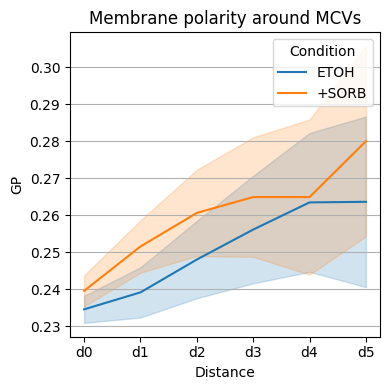

In [17]:
folder_list = ['h37 etoh', 'h37 +sorb']
conditions = ['etoh', '+sorb']
plt.figure(figsize=(4, 4))
    
for cond in conditions:
    folder = f"h37 {cond}"
    file_path = f"{directory_path}/{folder}/GP_transposed.csv"
    
    df = pandas.read_csv(file_path)
    df = df.drop(columns=df.columns[0])  # Drop unnamed index column
    df_melted = df.melt(var_name="Distance", value_name="GP")
    df_melted['Condition'] = cond  # Add a condition column for coloring
    
    # Plot each condition with its color
    seaborn.lineplot(
        data=df_melted,
        x="Distance",
        y="GP",
        errorbar='se',
        label=cond.upper(),
        color="#1f77b4" if cond == "etoh" else "#ff7f0e"
    )
result1 = f"{directory_path}/GP_MCV.tif"
result2 = f"{directory_path}/GP_MCV.svg"
plt.title(f"Membrane polarity around MCVs")
plt.xlabel("Distance")
plt.ylabel("GP")
plt.grid(axis='y')
plt.legend(title="Condition")
plt.tight_layout()
plt.savefig(result1)
plt.savefig(result2)
plt.show()